# LSTM using Fantasy Football Scout data

## Set-up 

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model, Model
from keras.layers import Dense, Flatten, LSTM, BatchNormalization, Input, Dropout, Activation, Bidirectional
from keras import initializers, optimizers

Using TensorFlow backend.


In [2]:
os.chdir('../..')

In [3]:
from src.models.utils import \
    _load_all_historical_data, \
    _map_season_string_to_ordered_numeric, \
    _generate_known_features_for_next_gw, \
    custom_train_test_split, \
    split_sequences, \
    _load_model_from_pickle
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING
from src.models.LSTM.make_predictions import LSTMPlayerPredictor
from src.visualisation.utils import plot_learning_curve

In [4]:
pd.options.display.max_columns = None

In [5]:
RANDOM_SEED = 3
N_STEPS_IN = 5
N_STEPS_OUT = 5

## Load FFS data

In [6]:
ffs_data = pd.read_parquet('data/external/fantasy_football_scout_data_1718_to_1819.parquet')
print(ffs_data.shape)
ffs_data.head()

(20449, 49)


,Name,Team,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,position,full_name,season,gw,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,name,total_points
0,Jesus,MCI,0,1,0,0,0,0,1,0,0,78,FWD,Gabriel Fernando de Jesus,2017-2018,1,0,0.0,0,2,4,9,7.8,0,69,0.07,1.33,0,0,0,0,2,0,0,0,4,0,2,0,0,0,2,80,25,0,2,0,gabriel_fernando de jesus,1
1,Welbeck,ARS,0,0,1,3,0,0,0,0,0,75,FWD,Danny Welbeck,2017-2018,1,0,50.0,0,2,3,29,12.9,43,57,0.23,0.98,1,0,1,0,2,1,2,1,2,0,1,1,0,0,1,76,21,0,0,4,danny_welbeck,6
2,Vokes,BUR,0,0,2,2,0,0,0,0,0,90,FWD,Sam Vokes,2017-2018,1,0,70.0,2,0,1,1,10.8,65,42,0.01,0.24,0,0,2,0,0,0,0,1,0,1,0,1,0,0,4,27,15,0,1,0,sam_vokes,10
3,Vardy,LEI,0,0,2,4,0,0,0,0,0,90,FWD,Jamie Vardy,2017-2018,1,0,33.3,1,1,1,5,14.1,68,68,0.01,0.89,0,0,0,0,0,0,0,1,4,0,0,1,0,0,0,82,11,0,0,1,jamie_vardy,10
4,Sakho (Diafra),WHU,0,0,0,2,0,0,0,0,0,30,FWD,Diafra Sakho,2017-2018,1,0,60.0,1,1,0,2,0.6,0,6,0.00,0.08,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,67,6,0,1,1,diafra_sakho,1


In [7]:
ffs_data.drop(columns=['Name', 'full_name'], inplace=True)

In [8]:
ffs_data.isnull().sum().sum()

0

In [9]:
ffs_data['season'].unique()

array(['2017-2018', '2018-2019'], dtype=object)

In [10]:
ffs_data_names = ffs_data[['name', 'Team', 'position']].drop_duplicates()
ffs_data_names['key'] = 1
ffs_data_names.shape

(721, 4)

In [11]:
seasons_df = pd.DataFrame({'season': ['2017-2018', '2018-2019']})
seasons_df['key'] = 1
seasons_df

,season,key
0,2017-2018,1
1,2018-2019,1


In [12]:
gw_df = pd.DataFrame({'gw': range(1, 39)})
gw_df['key'] = 1
gw_df.head()

,gw,key
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [13]:
all_season_gw_df = seasons_df.merge(gw_df, on='key')

In [14]:
all_player_season_gw_df = all_season_gw_df.merge(ffs_data_names, on='key')
all_player_season_gw_df.drop('key', axis=1, inplace=True)
all_player_season_gw_df.shape

(54796, 5)

In [15]:
ffs_data = all_player_season_gw_df.merge(ffs_data, on=['name', 'Team', 'position', 'gw', 'season'], how='left')
print(ffs_data.shape)
ffs_data.head()

(54796, 47)


,season,gw,name,Team,position,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points
0,2017-2018,1,gabriel_fernando de jesus,MCI,FWD,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,78.0,0.0,0.0,0.0,2.0,4.0,9.0,7.8,0.0,69.0,0.07,1.33,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,2.0,80.0,25.0,0.0,2.0,0.0,1.0
1,2017-2018,1,danny_welbeck,ARS,FWD,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,50.0,0.0,2.0,3.0,29.0,12.9,43.0,57.0,0.23,0.98,1.0,0.0,1.0,0.0,2.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,76.0,21.0,0.0,0.0,4.0,6.0
2,2017-2018,1,sam_vokes,BUR,FWD,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,70.0,2.0,0.0,1.0,1.0,10.8,65.0,42.0,0.01,0.24,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,27.0,15.0,0.0,1.0,0.0,10.0
3,2017-2018,1,jamie_vardy,LEI,FWD,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,33.3,1.0,1.0,1.0,5.0,14.1,68.0,68.0,0.01,0.89,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,82.0,11.0,0.0,0.0,1.0,10.0
4,2017-2018,1,diafra_sakho,WHU,FWD,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,60.0,1.0,1.0,0.0,2.0,0.6,0.0,6.0,0.00,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,67.0,6.0,0.0,1.0,1.0,1.0


In [16]:
ffs_data.sort_values(['name', 'season', 'gw'], inplace=True)
ffs_data.head()

,season,gw,name,Team,position,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points
253,2017-2018,1,aaron_cresswell,WHU,DEF,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0
974,2017-2018,2,aaron_cresswell,WHU,DEF,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,53.0,7.3,20.0,0.0,0.17,0.00,0.0,0.0,5.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,22.0,0.0,0.0,0.0,1.0
1695,2017-2018,3,aaron_cresswell,WHU,DEF,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,2.0,2.0,2.5,11.0,11.0,0.01,0.07,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,41.0,0.0,1.0,1.0,1.0
2416,2017-2018,4,aaron_cresswell,WHU,DEF,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,1.0,0.0,0.0,47.0,6.7,19.0,1.0,0.31,0.05,1.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,22.0,0.0,1.0,3.0,6.0
3137,2017-2018,5,aaron_cresswell,WHU,DEF,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,0.0,0.0,0.0,34.0,4.6,12.0,0.0,0.05,0.00,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,30.0,0.0,0.0,0.0,6.0


In [17]:
ffs_data.isnull().sum()

season                                  0
gw                                      0
name                                    0
Team                                    0
position                                0
Assists                             34347
Clean Sheets                        34347
Goals                               34347
Goals Conceded                      34347
Penalties Missed                    34347
Premier League Total Red Cards      34347
Premier League Yellow Cards         34347
Saves                               34347
Saves From Penalty                  34347
Time Played                         34347
Own Goals                           34347
Aerial Duels - Won - Percentage     34347
Attempts From Set Plays             34347
Big Chances Total                   34347
Chances From Open Play              34347
ICT Creativity                      34347
ICT Index                           34347
ICT Influence                       34347
ICT Threat                        

In [18]:
# From an offline check the missing entries are 0 minutes players in a given GW. We can therefore fill all missing data points with 0.
ffs_data.fillna(0, inplace=True)

In [19]:
ffs_data = pd.get_dummies(ffs_data, columns=['position'])

In [20]:
ffs_data.rename(columns={'Team': 'team_name'}, inplace=True)

### Create target

In [21]:
ffs_data['total_points_plus1_gw'] = ffs_data.groupby(['name'])['total_points'].shift(-1)
ffs_data = ffs_data[~ffs_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

In [22]:
ffs_data.head()

,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID,total_points_plus1_gw
253,2017-2018,1,aaron_cresswell,WHU,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0,1,0,0,0,1.0
974,2017-2018,2,aaron_cresswell,WHU,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,53.0,7.3,20.0,0.0,0.17,0.00,0.0,0.0,5.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,22.0,0.0,0.0,0.0,1.0,1,0,0,0,1.0
1695,2017-2018,3,aaron_cresswell,WHU,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,2.0,2.0,2.5,11.0,11.0,0.01,0.07,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,41.0,0.0,1.0,1.0,1.0,1,0,0,0,6.0
2416,2017-2018,4,aaron_cresswell,WHU,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,1.0,0.0,0.0,47.0,6.7,19.0,1.0,0.31,0.05,1.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,22.0,0.0,1.0,3.0,6.0,1,0,0,0,6.0
3137,2017-2018,5,aaron_cresswell,WHU,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,0.0,0.0,0.0,34.0,4.6,12.0,0.0,0.05,0.00,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,30.0,0.0,0.0,0.0,6.0,1,0,0,0,1.0


### Train/dev/test split

In [23]:
training_df, test_df = custom_train_test_split(ffs_data, random_state=RANDOM_SEED, rand_sample_prop=0.0027)
training_df.head()

Proportion in test set: 0.09862330222673935
Test set size: (5337, 52)
Training set size: (48778, 52)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID,total_points_plus1_gw
253,2017-2018,1,aaron_cresswell,WHU,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,1.0,1.0,1.9,0.0,18.0,0.00,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,10.0,0.0,0.0,0.0,0.0,1,0,0,0,1.0
974,2017-2018,2,aaron_cresswell,WHU,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,53.0,7.3,20.0,0.0,0.17,0.00,0.0,0.0,5.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,77.0,22.0,0.0,0.0,0.0,1.0,1,0,0,0,1.0
1695,2017-2018,3,aaron_cresswell,WHU,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,2.0,2.0,2.5,11.0,11.0,0.01,0.07,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,85.0,41.0,0.0,1.0,1.0,1.0,1,0,0,0,6.0
2416,2017-2018,4,aaron_cresswell,WHU,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,1.0,0.0,0.0,47.0,6.7,19.0,1.0,0.31,0.05,1.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0,22.0,0.0,1.0,3.0,6.0,1,0,0,0,6.0
3137,2017-2018,5,aaron_cresswell,WHU,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,50.0,0.0,0.0,0.0,34.0,4.6,12.0,0.0,0.05,0.00,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,30.0,0.0,0.0,0.0,6.0,1,0,0,0,1.0


In [24]:
training_df, dev_df = custom_train_test_split(training_df, random_state=RANDOM_SEED, rand_sample_prop=0.003)

Proportion in test set: 0.1134527860920907
Test set size: (5534, 52)
Training set size: (43244, 52)


/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
print(f"Proportion training: {training_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion dev: {dev_df.shape[0]/ffs_data.shape[0]}")
print(f"Proportion test: {test_df.shape[0]/ffs_data.shape[0]}")

Proportion training: 0.7991130000923958
Proportion dev: 0.10226369768086482
Proportion test: 0.09862330222673935


### Filter out ineligible players

In [26]:
def filter_eligible_players(training_subset_df):
    training_subset_df['total_number_of_gameweeks'] = training_subset_df.groupby(['name']).transform('count')['team_name']
    training_subset_df = training_subset_df[training_subset_df['total_number_of_gameweeks'] >= (N_STEPS_IN + N_STEPS_OUT - 1)]
    training_subset_df.drop('total_number_of_gameweeks', axis=1, inplace=True)
    
    return training_subset_df

In [27]:
training_df = filter_eligible_players(training_df)
dev_df = filter_eligible_players(dev_df)
test_df = filter_eligible_players(test_df)

### Normalise features

In [28]:
COLUMNS_TO_SCALE = list(training_df.select_dtypes('number').columns.drop('total_points_plus1_gw'))
len(COLUMNS_TO_SCALE)

47

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
mms = MinMaxScaler()

mms.fit(training_df[COLUMNS_TO_SCALE])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [31]:
set(training_df.columns) - set(COLUMNS_TO_SCALE)

{'name', 'season', 'team_name', 'total_points_plus1_gw'}

In [32]:
COLUMNS_TO_DROP_FOR_TRAINING = ['name', 'season', 'team_name']

### Prepare data for LSTM

In [33]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df = player_df[COLUMNS_TO_SCALE + ['total_points_plus1_gw']]

        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [34]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

(37960, 5, 47)
(37960, 5)
(4550, 5, 47)
(4550, 5)
(4357, 5, 47)
(4357, 5)


True split after filtering:

In [35]:
total_examples = X_train.shape[0] + X_dev.shape[0] + X_test.shape[0]
print(f"Proportion training: {X_train.shape[0]/total_examples}")
print(f"Proportion dev: {X_dev.shape[0]/total_examples}")
print(f"Proportion test: {X_test.shape[0]/total_examples}")

Proportion training: 0.8099515650671048
Proportion dev: 0.0970832355388653
Proportion test: 0.09296519939402992


### Fit model

In [36]:
def create_model():
    X_input = Input(shape=(N_STEPS_IN, 47,))
    
    X = LSTM(25, return_sequences=True)(X_input)
    X = Dropout(rate=0.1)(X)
    
    X = LSTM(25, return_sequences=False)(X)
    X = Dropout(rate=0.3)(X)
    
    X = Dense(10)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    output = Dense(N_STEPS_OUT, kernel_initializer=initializers.glorot_normal())(X)
    
    model = Model(inputs=X_input, outputs=output, name='new_lstm')
    
    # Compile
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [37]:
new_lstm_model = create_model()

In [38]:
new_lstm_model.summary()

Model: "new_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5, 47)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 25)             7300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 25)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_2 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40 

In [39]:
new_lstm_model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_dev, y_dev))

Train on 37960 samples, validate on 4550 samples
Epoch 1/100
37960/37960 [==============================] - 3s 81us/step - loss: 4.9148 - val_loss: 4.1997
Epoch 2/100
37960/37960 [==============================] - 2s 48us/step - loss: 4.3208 - val_loss: 3.6765
Epoch 3/100
37960/37960 [==============================] - 2s 47us/step - loss: 4.0237 - val_loss: 3.4205
Epoch 4/100
37960/37960 [==============================] - 2s 47us/step - loss: 3.7977 - val_loss: 3.2880
Epoch 5/100
37960/37960 [==============================] - 2s 47us/step - loss: 3.6534 - val_loss: 3.1716
Epoch 6/100
37960/37960 [==============================] - 2s 47us/step - loss: 3.5568 - val_loss: 3.1203
Epoch 7/100
37960/37960 [==============================] - 2s 47us/step - loss: 3.4853 - val_loss: 3.0624
Epoch 8/100
37960/37960 [==============================] - 2s 49us/step - loss: 3.4125 - val_loss: 3.0217
Epoch 9/100
37960/37960 [==============================] - 2s 49us/step - loss: 3.3727 - val_loss: 2.96

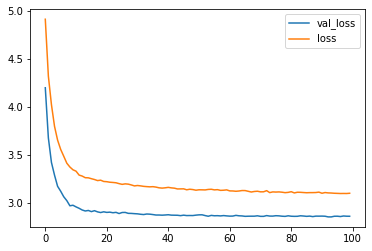

In [40]:
pd.DataFrame(new_lstm_model.history.history).plot()

In [41]:
from sklearn.metrics import mean_squared_error

In [42]:
mean_squared_error(y_dev, new_lstm_model.predict(X_dev))

2.8587927554088868

## Permutation feature importance

In [43]:
model_error = mean_squared_error(y_train, new_lstm_model.predict(X_train))

In [44]:
NUM_TRIALS = 1
pfi_dict = {}

for i, feature in enumerate(COLUMNS_TO_SCALE):
    print(feature, f'({i+1}/{len(COLUMNS_TO_SCALE)})')
    
    X_train_copy = np.copy(X_train)
    
    pfi_trials = []
    for trial in range(NUM_TRIALS):
    
        feature_array = X_train_copy[:, :, i]
        num_rows, num_cols = feature_array.shape

        shuffled_flattened = feature_array.flatten()

        np.random.shuffle(shuffled_flattened)  # shuffles in-place

        shuffled_array = shuffled_flattened.reshape(num_rows, num_cols)

        X_train_copy[:, :, i] = shuffled_array

        predictions_shuffled = new_lstm_model.predict(X_train_copy)

        model_error_perm = mean_squared_error(y_train, predictions_shuffled)

        pfi = model_error_perm / model_error

        pfi_trials.append(pfi)
        
    mean_pfi = np.mean(pfi_trials)
    std_pfi = np.std(pfi_trials)
    
    pfi_dict[feature] = {'mean': mean_pfi, 'std': std_pfi}

gw (1/47)
Assists (2/47)
Clean Sheets (3/47)
Goals (4/47)
Goals Conceded (5/47)
Penalties Missed (6/47)
Premier League Total Red Cards (7/47)
Premier League Yellow Cards (8/47)
Saves (9/47)
Saves From Penalty (10/47)
Time Played (11/47)
Own Goals (12/47)
Aerial Duels - Won - Percentage (13/47)
Attempts From Set Plays (14/47)
Big Chances Total (15/47)
Chances From Open Play (16/47)
ICT Creativity (17/47)
ICT Index (18/47)
ICT Influence (19/47)
ICT Threat (20/47)
xA Expected Assists (21/47)
xG Expected Goals (22/47)
Big Chances Created (23/47)
Blocks (24/47)
Clearances (25/47)
Crosses - Open Play - Successful (26/47)
Dribbles - Successful (27/47)
Interceptions (28/47)
Key Passes (29/47)
Net Tackles (30/47)
Recoveries (31/47)
Winning Goal (32/47)
Big Chances Missed (33/47)
Caught Offside (34/47)
Errors Leading to Chance (35/47)
Errors Leading to Goal (36/47)
Fouls Conceded (37/47)
Pass Completion (38/47)
Passes (39/47)
Penalties Conceded (40/47)
Shots Off Target (41/47)
Tackled (42/47)
to

In [45]:
pfi_df = pd.DataFrame(pfi_dict).T
pfi_df.sort_values('mean', ascending=False, inplace=True)
pfi_df

,mean,std
Time Played,1.062215,0.0
Pass Completion,1.049532,0.0
position_MID,1.048008,0.0
position_DEF,1.034014,0.0
position_FWD,1.033683,0.0
Passes,1.016828,0.0
position_GK,1.007416,0.0
ICT Threat,1.005490,0.0
ICT Index,1.004930,0.0
Caught Offside,1.003910,0.0


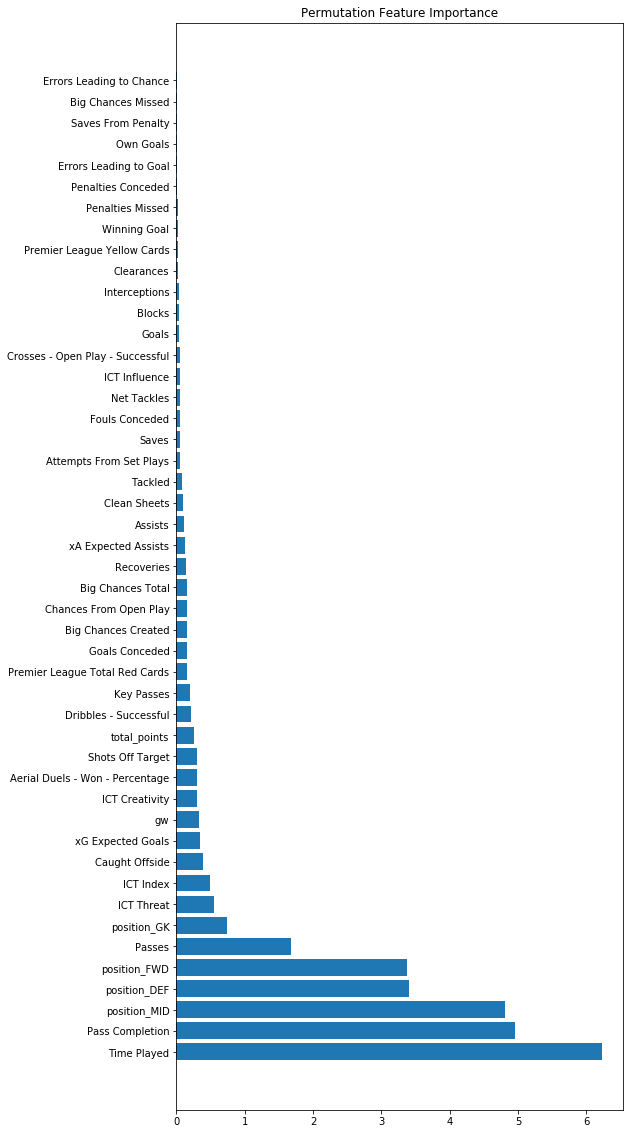

In [46]:
plt.figure(figsize=(8, 20))
plt.barh(
    pfi_df.index, 
    (pfi_df['mean'] - 1) * 100
)
plt.title('Permutation Feature Importance')
plt.show()

## Single round of feature dropping and re-fitting

In [47]:
PFI_CUTOFF = 1.0002
FEATURES_TO_DROP = list(pfi_df[pfi_df['mean'] < PFI_CUTOFF].index)
FEATURES_TO_DROP

['Penalties Missed',
 'Penalties Conceded',
 'Errors Leading to Goal',
 'Own Goals',
 'Saves From Penalty',
 'Big Chances Missed',
 'Errors Leading to Chance']

In [48]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df = player_df[COLUMNS_TO_SCALE + ['total_points_plus1_gw']]
        
        player_df.drop(columns=FEATURES_TO_DROP, inplace=True)

        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [49]:
X_train, y_train = prepare_data_for_lstm(training_df)
X_dev, y_dev = prepare_data_for_lstm(dev_df)
X_test, y_test = prepare_data_for_lstm(test_df)

(37960, 5, 40)
(37960, 5)
(4550, 5, 40)
(4550, 5)
(4357, 5, 40)
(4357, 5)


In [50]:
def create_model():
    X_input = Input(shape=(N_STEPS_IN, 40,))
    
    X = LSTM(25, return_sequences=True)(X_input)
    X = Dropout(rate=0.1)(X)
    
    X = LSTM(25, return_sequences=False)(X)
    X = Dropout(rate=0.25)(X)
    
    X = Dense(25)(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.2)(X)
    
    output = Dense(N_STEPS_OUT, kernel_initializer=initializers.glorot_normal())(X)
    
    model = Model(inputs=X_input, outputs=output, name='new_lstm')
    
    # Compile
    optimizer = optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='mse', optimizer=optimizer)
    
    return model

In [51]:
new_lstm_model = create_model()

In [52]:
new_lstm_model.summary()

Model: "new_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5, 40)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 25)             6600      
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 25)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_5 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
batch_normalization_2 (Batch (None, 25)                100

In [53]:
new_lstm_model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_dev, y_dev))

Train on 37960 samples, validate on 4550 samples
Epoch 1/100
37960/37960 [==============================] - 3s 74us/step - loss: 4.7075 - val_loss: 4.1014
Epoch 2/100
37960/37960 [==============================] - 2s 46us/step - loss: 3.9320 - val_loss: 3.3198
Epoch 3/100
37960/37960 [==============================] - 2s 47us/step - loss: 3.6280 - val_loss: 3.0764
Epoch 4/100
37960/37960 [==============================] - 2s 50us/step - loss: 3.4883 - val_loss: 2.9981
Epoch 5/100
37960/37960 [==============================] - 2s 48us/step - loss: 3.4068 - val_loss: 2.9697
Epoch 6/100
37960/37960 [==============================] - 2s 48us/step - loss: 3.3593 - val_loss: 2.9450
Epoch 7/100
37960/37960 [==============================] - 2s 48us/step - loss: 3.3249 - val_loss: 2.9365
Epoch 8/100
37960/37960 [==============================] - 2s 48us/step - loss: 3.3109 - val_loss: 2.9232
Epoch 9/100
37960/37960 [==============================] - 2s 48us/step - loss: 3.2795 - val_loss: 2.92

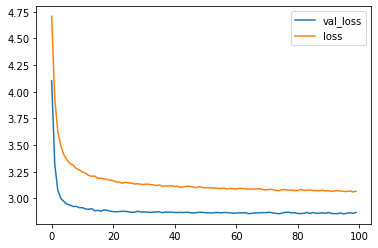

In [54]:
pd.DataFrame(new_lstm_model.history.history).plot()

In [55]:
mean_squared_error(y_dev, new_lstm_model.predict(X_dev))

2.868448230970624

### PFI

In [56]:
model_error = mean_squared_error(y_train, new_lstm_model.predict(X_train))

In [57]:
FEATURES_V2 = list(training_df[COLUMNS_TO_SCALE + ['total_points_plus1_gw']].drop(FEATURES_TO_DROP + ['total_points_plus1_gw'], axis=1).columns)

In [58]:
NUM_TRIALS = 1
pfi_dict = {}

for i, feature in enumerate(FEATURES_V2):
    print(feature, f'({i+1}/{len(FEATURES_V2)})')
    
    X_train_copy = np.copy(X_train)
    
    pfi_trials = []
    for trial in range(NUM_TRIALS):
    
        feature_array = X_train_copy[:, :, i]
        num_rows, num_cols = feature_array.shape

        shuffled_flattened = feature_array.flatten()

        np.random.shuffle(shuffled_flattened)  # shuffles in-place

        shuffled_array = shuffled_flattened.reshape(num_rows, num_cols)

        X_train_copy[:, :, i] = shuffled_array

        predictions_shuffled = new_lstm_model.predict(X_train_copy)

        model_error_perm = mean_squared_error(y_train, predictions_shuffled)

        pfi = model_error_perm / model_error

        pfi_trials.append(pfi)
        
    mean_pfi = np.mean(pfi_trials)
    std_pfi = np.std(pfi_trials)
    
    pfi_dict[feature] = {'mean': mean_pfi, 'std': std_pfi}

gw (1/40)
Assists (2/40)
Clean Sheets (3/40)
Goals (4/40)
Goals Conceded (5/40)
Premier League Total Red Cards (6/40)
Premier League Yellow Cards (7/40)
Saves (8/40)
Time Played (9/40)
Aerial Duels - Won - Percentage (10/40)
Attempts From Set Plays (11/40)
Big Chances Total (12/40)
Chances From Open Play (13/40)
ICT Creativity (14/40)
ICT Index (15/40)
ICT Influence (16/40)
ICT Threat (17/40)
xA Expected Assists (18/40)
xG Expected Goals (19/40)
Big Chances Created (20/40)
Blocks (21/40)
Clearances (22/40)
Crosses - Open Play - Successful (23/40)
Dribbles - Successful (24/40)
Interceptions (25/40)
Key Passes (26/40)
Net Tackles (27/40)
Recoveries (28/40)
Winning Goal (29/40)
Caught Offside (30/40)
Fouls Conceded (31/40)
Pass Completion (32/40)
Passes (33/40)
Shots Off Target (34/40)
Tackled (35/40)
total_points (36/40)
position_DEF (37/40)
position_FWD (38/40)
position_GK (39/40)
position_MID (40/40)


In [59]:
pfi_df_v2 = pd.DataFrame(pfi_dict).T
pfi_df_v2.sort_values('mean', ascending=False, inplace=True)
pfi_df_v2

,mean,std
Time Played,1.080119,0.0
Pass Completion,1.048984,0.0
position_MID,1.033244,0.0
position_FWD,1.026015,0.0
position_DEF,1.022118,0.0
Passes,1.016019,0.0
ICT Threat,1.006008,0.0
ICT Index,1.005314,0.0
Caught Offside,1.004835,0.0
gw,1.004304,0.0


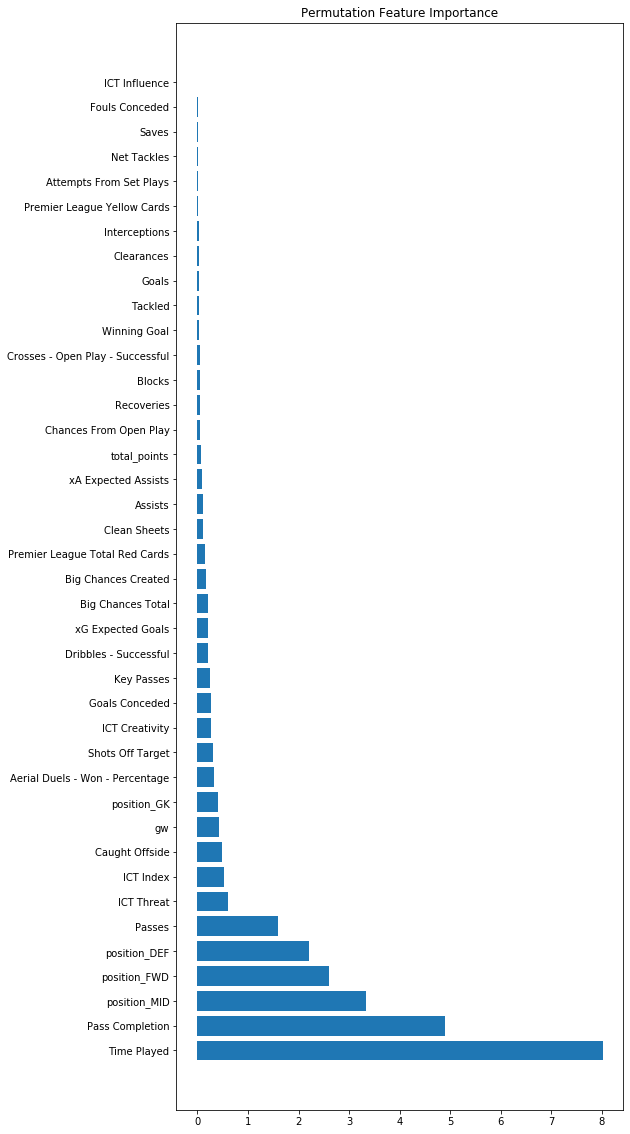

In [60]:
plt.figure(figsize=(8, 20))
plt.barh(
    pfi_df_v2.index, 
    (pfi_df_v2['mean'] - 1) * 100
)
plt.title('Permutation Feature Importance')
plt.show()

## Is it better than model with FPL data?

Steps:
- Get FPL data
- Created dev/test set flag in FFS data
- Inner join FPL and FFS and keep dev (and test if more needed)
- Make predictions with FPL model
- Make predictions with FFS model
- Bootstrap in both instances before comparing

In [96]:
def load_all_data():
    full_data = _load_all_historical_data()
    full_data.sort_values(['name', 'season', 'gw'], inplace=True)

    _map_season_string_to_ordered_numeric(full_data)
    _generate_known_features_for_next_gw(full_data)

    # Remove Brendan Galloway due to unexplained gap in gameweek data
    full_data = full_data[full_data['name'] != 'brendan_galloway']
    full_data.drop('ID', axis=1, inplace=True)

#     logging.info(f"Loaded historical data of shape {full_data.shape}")

    return full_data

In [97]:
all_data = load_all_data()

2020-08-05 12:19:24,649 - Loading raw historical FPL data
2020-08-05 12:19:24,734 - Creating season order column
2020-08-05 12:19:24,741 - Generating known features for next GW


In [98]:
all_data.head()

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,1,0,14023,1,2,0.0,0,0,0,0,5.5,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Chelsea,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,5.5,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,2,0,11531,0,1,0.0,0,-3002,79,3081,5.5,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Bournemouth,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,3,0,9587,1,3,0.0,0,-2053,28,2081,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Manchester City,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,4,0,8427,4,2,0.0,0,-1221,45,1266,5.4,True,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,Watford,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,5,0,7933,2,4,0.0,0,-520,29,549,5.4,False,0,aaron_cresswell,West Ham United,0,0,2016-17,1,0,0,0,West Bromwich Albion,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,5.4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
all_data['season'].unique()

array(['2016-17', '2017-18', '2018-19'], dtype=object)

In [100]:
fpl_data = all_data.copy()[all_data['season'].isin(['2017-18', '2018-19'])]
fpl_data.shape

(44155, 68)

In [101]:
dev_df_copy = dev_df.copy()
dev_df_copy['type'] = 'dev'
test_df_copy = test_df.copy()
test_df_copy['type'] = 'test'

ffs_comparison_df = dev_df_copy.append(test_df_copy)
ffs_comparison_df.shape

(10771, 52)

In [102]:
ffs_comparison_df['season'].unique()

array(['2017-2018', '2018-2019'], dtype=object)

In [103]:
ffs_comparison_df['season'].replace({'2017-2018': '2017-18', '2018-2019': '2018-19'}, inplace=True)

In [104]:
comp_df = ffs_comparison_df.merge(fpl_data, on=['name', 'gw', 'season'], how='inner')
print(comp_df.shape)
comp_df.head()

(7547, 117)


,season,gw,name,team_name_x,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points_x,position_DEF_x,position_FWD_x,position_GK_x,position_MID_x,total_points_plus1_gw,type,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,saves,selected,team_a_score,team_h_score,threat,total_points_y,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,team_name_y,promoted_side,top_6_last_season,position_DEF_y,position_FWD_y,position_GK_y,position_MID_y,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff
0,2017-18,18,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,dev,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,3,0,0.0,0,0,0,0,4.5,False,0,Crystal Palace,0,0,0,0,0,1,Leicester City,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-18,18,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0,dev,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,0,3,0,0.0,0,0,0,0,4.5,False,0,Crystal Palace,0,0,0,0,0,1,Leicester City,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-18,19,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,dev,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,42,1,1,0.0,0,17,28,11,4.5,False,0,Crystal Palace,0,0,0,0,0,1,Swansea City,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,4.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2017-18,19,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0,dev,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,42,1,1,0.0,0,17,28,11,4.5,False,0,Crystal Palace,0,0,0,0,0,1,Swansea City,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,4.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2017-18,20,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,dev,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,0,55,3,2,0.0,0,2,20,18,4.5,True,0,Crystal Palace,0,0,0,0,0,1,Arsenal,0,1,1,0,0,0,0,0,1,0,0,0,0,0,2,4.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,

In [105]:
comp_df['type'].value_counts()

test    3951
dev     3596
Name: type, dtype: int64

Use both dev and test for comparison

In [106]:
comp_df_names = comp_df[['name', 'gw', 'season']].drop_duplicates()

In [107]:
comp_df_names.shape

(6558, 3)

### FPL predictions

In [108]:
fpl_data = fpl_data.merge(comp_df_names, on=['name', 'gw', 'season'], how='inner')

In [109]:
fpl_data.shape

(6825, 68)

In [110]:
mms_old = _load_model_from_pickle('src/models/pickles/min_max_scalar_lstm_v4.pickle')
COLUMNS_TO_SCALE_old = _load_model_from_pickle('src/models/pickles/min_max_scalar_columns_v4.pickle')

In [111]:
fpl_data['total_points_plus1_gw'] = fpl_data.groupby(['name'])['total_points'].shift(-1)
fpl_data = fpl_data[~fpl_data['total_points_plus1_gw'].isnull()]  # drop nulls (last gw)

### Filter out ineligible players

In [112]:
fpl_data = filter_eligible_players(fpl_data)
fpl_data.shape

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(6566, 69)

In [113]:
from src.models.constants import \
    COLUMNS_TO_DROP_FOR_TRAINING as COLUMNS_TO_DROP_FOR_TRAINING_old

In [114]:
fpl_data.head()

,assists,bonus,bps,clean_sheets,creativity,goals_conceded,goals_scored,ict_index,influence,minutes,own_goals,penalties_missed,penalties_saved,red_cards,gw,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,name,team_name,promoted_side,top_6_last_season,season,position_DEF,position_FWD,position_GK,position_MID,team_name_opponent,promoted_side_opponent,top_6_last_season_opponent,late_kickoff,early_kickoff,kickoff_month_Aug,kickoff_month_Sep,kickoff_month_Oct,kickoff_month_Nov,kickoff_month_Dec,kickoff_month_Jan,kickoff_month_Feb,kickoff_month_Mar,kickoff_month_Apr,kickoff_month_May,season_order,next_match_value,next_match_was_home,next_match_promoted_side_opponent,next_match_top_6_last_season_opponent,next_match_kickoff_month_Aug,next_match_kickoff_month_Sep,next_match_kickoff_month_Oct,next_match_kickoff_month_Nov,next_match_kickoff_month_Dec,next_match_kickoff_month_Jan,next_match_kickoff_month_Feb,next_match_kickoff_month_Mar,next_match_kickoff_month_Apr,next_match_kickoff_month_May,next_match_late_kickoff,next_match_early_kickoff,total_points_plus1_gw
8,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,18,0,0,3,0,0.0,0,0,0,0,4.5,False,0,aaron_wan-bissaka,Crystal Palace,0,0,2017-18,0,0,0,1,Leicester City,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,19,0,42,1,1,0.0,0,17,28,11,4.5,False,0,aaron_wan-bissaka,Crystal Palace,0,0,2017-18,0,0,0,1,Swansea City,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,4.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,20,0,55,3,2,0.0,0,2,20,18,4.5,True,0,aaron_wan-bissaka,Crystal Palace,0,0,2017-18,0,0,0,1,Arsenal,0,1,1,0,0,0,0,0,1,0,0,0,0,0,2,4.5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
11,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,21,0,67,0,0,0.0,0,6,12,6,4.5,True,0,aaron_wan-bissaka,Crystal Palace,0,0,2017-18,0,0,0,1,Manchester City,0,1,0,1,0,0,0,0,1,0,0,0,0,0,2,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,0,0,0,0,0.0,0,0,0.0,0.0,0,0,0,0,0,22,0,75,2,1,0.0,0,4,14,10,4.5,False,0,aaron_wan-bissaka,Crystal Palace,0,0,2017-18,0,0,0,1,Southampton,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2,4.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [115]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE_old] = mms_old.transform(df[COLUMNS_TO_SCALE_old])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df.drop(
            COLUMNS_TO_DROP_FOR_TRAINING_old,
            axis=1,
            inplace=True
        )
        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [116]:
X_train, y_train = prepare_data_for_lstm(fpl_data)

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(5174, 5, 63)
(5174, 5)


In [117]:
current_lstm_model = load_model("src/models/pickles/v4_lstm_model.h5")

In [127]:
mse_list = []

for trial in range(100):
    idx = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    predictions_old_model = current_lstm_model.predict(X_train[idx, :, :])
    
    mse = mean_squared_error(y_train[idx], predictions_old_model)
    
    mse_list.append(mse)

In [128]:
np.mean(mse_list)

5.462456183865537

In [129]:
np.percentile(mse_list, 5)

5.243783639682325

In [130]:
np.percentile(mse_list, 95)

5.724579235526357

### FFS predictions

In [131]:
ffs_comparison_df.head()

,season,gw,name,team_name,Assists,Clean Sheets,Goals,Goals Conceded,Penalties Missed,Premier League Total Red Cards,Premier League Yellow Cards,Saves,Saves From Penalty,Time Played,Own Goals,Aerial Duels - Won - Percentage,Attempts From Set Plays,Big Chances Total,Chances From Open Play,ICT Creativity,ICT Index,ICT Influence,ICT Threat,xA Expected Assists,xG Expected Goals,Big Chances Created,Blocks,Clearances,Crosses - Open Play - Successful,Dribbles - Successful,Interceptions,Key Passes,Net Tackles,Recoveries,Winning Goal,Big Chances Missed,Caught Offside,Errors Leading to Chance,Errors Leading to Goal,Fouls Conceded,Pass Completion,Passes,Penalties Conceded,Shots Off Target,Tackled,total_points,position_DEF,position_FWD,position_GK,position_MID,total_points_plus1_gw,type
355,2017-18,1,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,dev
618,2017-18,1,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0,dev
1076,2017-18,2,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,dev
1339,2017-18,2,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0.0,dev
1797,2017-18,3,aaron_wan-bissaka,CRY,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0.0,dev


In [132]:
ffs_comparison_df.drop('type', axis=1, inplace=True)

In [133]:
comp_df_names.shape

(6558, 3)

In [134]:
ffs_comparison_df = ffs_comparison_df.merge(comp_df_names, on=['name', 'season', 'gw'], how='inner')

In [135]:
ffs_comparison_df.shape

(7260, 51)

In [136]:
ffs_comparison_df = filter_eligible_players(ffs_comparison_df)
ffs_comparison_df.shape

/Users/stevengeorge/opt/anaconda3/envs/fpl-analysis/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(7196, 51)

In [137]:
def prepare_data_for_lstm(df):
    df = df.copy()    
    df[COLUMNS_TO_SCALE] = mms.transform(df[COLUMNS_TO_SCALE])

    X_list = []
    y_list = []

    for player in list(df['name'].unique()):
        player_df = df[df['name'] == player]
        player_df = player_df[COLUMNS_TO_SCALE + ['total_points_plus1_gw']]
        
        player_df.drop(columns=FEATURES_TO_DROP, inplace=True)

        X_player, y_player = split_sequences(
            df=player_df,
            target_column='total_points_plus1_gw',
            n_steps_in=N_STEPS_IN,
            n_steps_out=N_STEPS_OUT
        )
        X_list.append(X_player)
        y_list.append(y_player)

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    print(X.shape)
    print(y.shape)
    
    return X, y

In [138]:
X_train, y_train = prepare_data_for_lstm(ffs_comparison_df)

(5788, 5, 40)
(5788, 5)


In [139]:
mse_list_new = []

for trial in range(100):
    idx = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
    predictions_new_model = new_lstm_model.predict(X_train[idx, :, :])
    
    mse = mean_squared_error(y_train[idx], predictions_new_model)
    
    mse_list_new.append(mse)

In [140]:
np.mean(mse_list_new)

3.6814404306180957

In [141]:
np.percentile(mse_list_new, 5)

3.54307915771782

In [142]:
np.percentile(mse_list_new, 95)

3.842129851763617

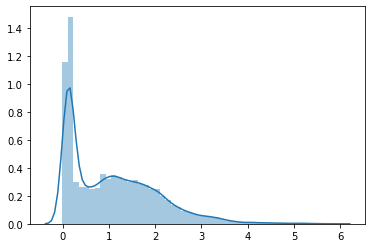

In [143]:
sns.distplot(predictions_new_model.flatten())
plt.show()

How different is the constructed target from the actual?

In [144]:
np.abs(
    comp_df['total_points_x'] - (comp_df['total_points_y'] - comp_df['bonus'])
).value_counts() / comp_df.shape[0]

0.0     0.905260
1.0     0.031933
2.0     0.025043
3.0     0.014045
5.0     0.006493
6.0     0.006493
4.0     0.005698
7.0     0.002385
8.0     0.001590
11.0    0.000398
10.0    0.000398
9.0     0.000265
dtype: float64

## TODO Add fixture/team level data to the model

## TODO Get cost data from FFS

__Conclusions__

- FFS data looks promosing with a bootstrapped MSE of 3.68 vs 5.46 for the current model on a comparable dataset.
- May be worth getting full feature set due to surprising features e.g. passes completed.